<a href="https://colab.research.google.com/github/Nilanshrajput/AdvitiyaHackathon/blob/master/fastai_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 481kB 8.9MB/s 
     |████████████████████████████████| 3.1MB 51kB/s 
     |████████████████████████████████| 1.0MB 44.5MB/s 
     |████████████████████████████████| 870kB 61.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=4b167befa0512313a2468088e71864bd923aeb0dca552821a6a528d1396e1d41
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [2]:
import torch
import numpy as np
import pandas as pd
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch import nn

from time import time

In [0]:
from fastai.text import *

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive_pt="/content/drive/My Drive/dl_projects/AdvitiyaHackathon/"

git_path = "AdvitiyaHackathon/"
path = drive_pt+"ScrappeData"

In [0]:
df1 = pd.read_csv(drive_pt+"final_train_clean.csv",index_col=0)
df2 = pd.read_csv(drive_pt+"final_val_clean.csv", index_col=0)

In [36]:
df1 = df1.sample(frac=1).reset_index(drop=True)
df2 = df2.sample(frac=1).reset_index(drop=True)
df1 = df1.dropna()
df2=df2.dropna()
print(df2.shape)

(80, 2)


In [0]:
df1.to_csv(drive_pt+"final_train_clean.csv")
df2.to_csv(drive_pt+"final_val_clean.csv")

In [28]:
df2.head()

,text,cat
0,system method use specialize computer soft...,1
1,small scale grain malt apparatus method ...,1
2,method pattern protective film vehicle met...,2
3,slow citrus juicer combination human...,0
4,carbonate beverage contain hop oxidation r...,0


In [7]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [0]:
#from keras.preprocessing.sequence import pad_sequences


class LoadDataset(Dataset):

    def __init__(self, filename, maxlen):

        # Store the contents of the file in a pandas dataframe
        self.df = pd.read_csv(filename, delimiter=',',index_col=0)

        # Initialize the BERT tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Define the Maxlength for padding/truncating
        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        # Selecting the sentence and label at the specified index in the data frame
        sentence = self.df.loc[index, 'text']
        label = torch.tensor((self.df.loc[index, 'cat']))

        # Tokenize the sentence
        tokens_ids = self.tokenizer.encode(str(sentence),add_special_tokens = True,max_length = self.maxlen, pad_to_max_length=True)
        """
        tokens_ids = pad_sequences([tokens_ids], maxlen=self.maxlen, dtype="long", 
                          value=0, truncating="post", padding="post")
        """   
        # Inserting the CLS and SEP token at the beginning and end of the sentence
        #tokens = ['[CLS]'] + tokens 
        """
        if len(tokens_ids) < self.maxlen:
            tokens_ids = [tokens_ids + [0] for _ in range(self.maxlen - len(tokens_ids))]
        else:
            tokens_ids = tokens_ids[:self.maxlen-1]         
        """  
        # Padding/truncating the sentences to the maximum length


        # Convert the sequence to ids with BERT Vocabulary
        #tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        
        # Converting the list to a pytorch tensor
        tokens_ids_tensor = torch.tensor(tokens_ids)

        # Obtaining the attention mask
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label

In [0]:
# Creating instances of training and validation set
train_set = LoadDataset(filename = drive_pt+'final_train_clean.csv', maxlen = 224)
val_set = LoadDataset(filename = drive_pt+'final_val_clean.csv', maxlen = 224)

In [0]:
# Creating intsances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size = 32, shuffle = True, num_workers = 5)
val_loader = DataLoader(val_set, batch_size = 32, shuffle = True, num_workers = 5)

In [0]:
databunch = DataBunch(train_dl= train_loader, valid_dl=val_loader)

In [0]:
#batch = next(iter(train_loader))

In [0]:
#batch

In [0]:

class PatentClassifier(nn.Module):

    def __init__(self, freeze_bert = True):
        super(PatentClassifier, self).__init__()

        # Instantiating the BERT model object 
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        
        # Defining layers like dropout and linear
        self.dropout = nn.Dropout(0.15)
        self.classifier = nn.Linear(768, 4)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        # Getting contextualized representations from BERT Layer
        cont_reps, _ = self.bert_layer(seq, attention_mask = attn_masks)

        # Obtaining the representation of [CLS] head
        cls_rep = cont_reps[:, 0]
        # print('CLS shape: ',cls_rep.shape)

        # Feeding cls_rep to the classifier layer
        logits = self.classifier(cls_rep)
        # print('Logits shape: ',logits.shape)

        return logits
        
        

In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = True, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

#model = PatentClassifier(freeze_bert= False)

# Tell pytorch to run this model on the GPU.
#model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [38]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [26]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy])
"""
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
"""

'\noptimizer = AdamW(model.parameters(),\n                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5\n                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.\n                )\n'

In [27]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


ValueError: ignored

In [40]:
data_lm = TextLMDataBunch.from_csv(drive_pt, 'final_train_clean.csv',text_cols="text", label_cols="cat")
# Classifier model data
data_clas = TextClasDataBunch.from_csv(drive_pt, 'final_train_clean.csv', vocab=data_lm.train_ds.vocab, bs=32,text_cols="text", label_cols="cat")

In [0]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [0]:
data_lm = load_data( drive_pt,'data_lm_export.pkl')
data_clas = load_data( drive_pt,'data_clas_export.pkl', bs=32)


In [46]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


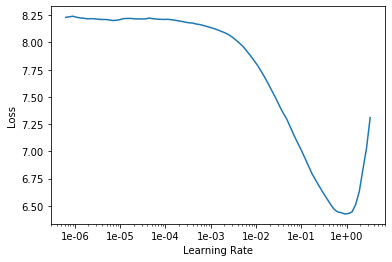

In [47]:
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(1, 1.2e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,3.845475,2.882146,0.513082,00:13


In [49]:
learn.unfreeze()
learn.fit_one_cycle(4,1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.387474,2.069469,0.649394,00:13
1,1.867622,1.713233,0.707677,00:13
2,1.451768,1.500046,0.744906,00:13
3,1.056798,1.457307,0.758171,00:13


In [0]:
learn.save_encoder('ft_enc')

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.8)
learn.load_encoder('ft_enc')

In [0]:
data_clas.show_batch()


In [53]:
learn.fit_one_cycle(3, 1.2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.989414,0.739594,0.816964,00:18
1,0.714071,0.402202,0.848214,00:21
2,0.597162,0.378472,0.848214,00:22


In [54]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(2e-2/2.6**4, 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.519964,0.352613,0.861607,00:18
1,0.446283,0.290745,0.883929,00:21
2,0.347002,0.281583,0.888393,00:23


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


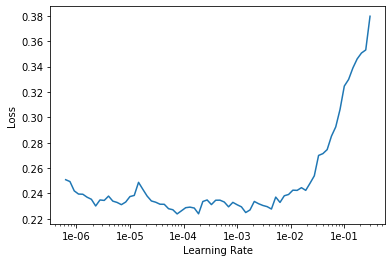

In [55]:
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(1, 1.3e-5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.234167,0.282080,0.888393,00:20


In [57]:
learn.fit_one_cycle(4, 1.3e-5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.233298,0.284207,0.888393,00:21
1,0.230197,0.281637,0.883929,00:22
2,0.228394,0.289709,0.888393,00:20
3,0.219605,0.300233,0.883929,00:21


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


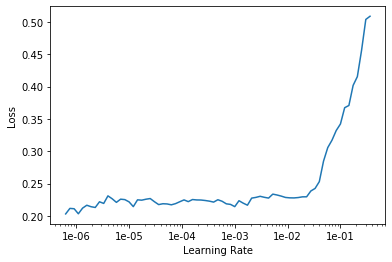

In [58]:
learn.lr_find()
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7)) #1

epoch,train_loss,valid_loss,accuracy,time
0,0.320694,0.317645,0.870536,00:20


In [60]:
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7)) #2

epoch,train_loss,valid_loss,accuracy,time
0,0.237058,0.287598,0.883929,00:20
1,0.209639,0.274154,0.897321,00:21
2,0.193831,0.272115,0.879464,00:21


In [61]:
learn.fit_one_cycle(10, 1e-4, moms=(0.8,0.7)) #3

epoch,train_loss,valid_loss,accuracy,time
0,0.174415,0.273901,0.888393,00:21
1,0.172118,0.270621,0.879464,00:19
2,0.173269,0.269492,0.897321,00:20
3,0.169500,0.274349,0.897321,00:20
4,0.162201,0.273215,0.892857,00:19
5,0.165314,0.268539,0.897321,00:23
6,0.162173,0.268217,0.901786,00:18
7,0.158223,0.264510,0.901786,00:18
8,0.156163,0.274979,0.888393,00:18
9,0.156798,0.268298,0.897321,00:23


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


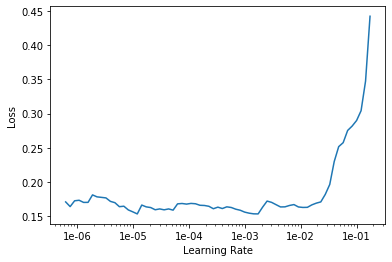

In [62]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.save('final9')

In [0]:
"""list_layers = [learner.model..distilbert.embeddings,
               learner.model.transformer.distilbert.transformer.layer[0] ,
               learner.model.transformer.distilbert.transformer.layer[1],
               learner.model.transformer.distilbert.transformer.layer[2],
               learner.model.transformer.distilbert.transformer.layer[3],
               learner.model.transformer.distilbert.transformer.layer[4],
               learner.model.transformer.distilbert.transformer.layer[5],
               learner.model.transformer.pre_classifier]
  """             


In [0]:
print

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 50

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [18]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [0]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_loader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
       
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_loader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in val_loader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 50 ========
Training...

  Average training loss: 0.95
  Training epcoh took: 0:00:52

Running Validation...
  Accuracy: 0.83
  Validation took: 0:00:03

======== Epoch 2 / 50 ========
Training...

  Average training loss: 0.40
  Training epcoh took: 0:00:53

Running Validation...
  Accuracy: 0.94
  Validation took: 0:00:03

======== Epoch 3 / 50 ========
Training...

  Average training loss: 0.18
  Training epcoh took: 0:00:54

Running Validation...
  Accuracy: 0.96
  Validation took: 0:00:03

======== Epoch 4 / 50 ========
Training...

  Average training loss: 0.07
  Training epcoh took: 0:00:53

Running Validation...
  Accuracy: 0.94
  Validation took: 0:00:03

======== Epoch 5 / 50 ========
Training...

  Average training loss: 0.03
  Training epcoh took: 0:00:53

Running Validation...
  Accuracy: 0.97
  Validation took: 0:00:03

======== Epoch 6 / 50 ========
Training...

  Average training loss: 0.02
  Training epcoh took: 0:00:53

Running Validation...
  Accu

KeyboardInterrupt: ignored

In [0]:
# Saving our model
import os
save_path = drive_pt+ "Models/"
if not os.path.isdir(save_path):
    os.mkdir(save_path)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, save_path+'bertv2_224_32_50.pth')

In [0]:
import re
location = "d125sd{g5d"
letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(location))

In [0]:
letters_only

'd   sd g d'

In [0]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

print(device)

cuda


In [0]:
# Defining a function for calculating accuracy
def logits_accuracy(logits, labels):
    probs = torch.sigmoid(logits.unsqueeze(-1))
    preds = (probs > 0.5).long()
    acc = (preds.squeeze() == labels).float().mean()
    return acc

In [0]:
# Defining an evaluation function for training 
def evaluate(net, criterion, val_loader, device):
  
    losses, accuracies = 0, 0
    
    # Setting model to evaluation mode
    net.eval()

    count = 0
    for (seq, attn_masks, labels) in val_loader:
        count += 1

        # Move inputs and targets to device
        seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)

        # Get logit predictions
        val_logits = net(seq, attn_masks)

        # Calculate loss
        val_loss = criterion(val_logits.squeeze(-1), labels.float())
        losses += val_loss.item()

        # Calculate validation accuracy
        accuracies += logits_accuracy(val_logits, labels)

    return losses / count, accuracies / count

In [0]:
def train(net, criterion, optimizer, train_loader, val_loader, device, epochs=4, print_every=100):
    
    # Move model to device
    net.to(device)
    # Setting model to training mode
    net.train()

    print('========== ========== STARTING TRAINING ========== ==========')

    for epoch in range(epochs):

        print('\n\n========== EPOCH {} =========='.format(epoch))        
        t1 = time()

        for i, (seq, attn_masks, labels) in enumerate(train_loader):

            # Clear gradients
            optimizer.zero_grad()  

            # Moving tensors to device
            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)

            # Obtaining the logits from the model
            logits = net(seq,attn_masks)

            # Calculating the loss
            loss = criterion(logits.squeeze(-1), labels.float())

            # Backpropagating the gradients
            loss.backward()

            # Clipping gradients to tackle exploding gradients
            nn.utils.clip_grad_norm_(net.parameters(), 1)

            # Optimization step
            optimizer.step()

            if (i + 1) % print_every == 0:
                print("Iteration {} ==== Loss: {}".format(i+1, loss.item()))

        t2 = time()
        print('Time Taken for Epoch: {}'.format(t2-t1))
        print('\n========== Validating ==========')
        mean_val_loss, mean_val_acc = evaluate(net, criterion, val_loader, device)
        print("Validation Loss: {}\nValidation Accuracy: {}".format(mean_val_loss, mean_val_acc))
